In [1]:
import dill
import itertools
import numpy as np
import multiprocessing
from pauli_channel_approximation import compute_dpn_and_fid
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

In [2]:
%%bash 
ls

Example data unpacking.ipynb
GRAPE.py
pauli_channel_approximation.py
pickled_controls228.pkl
pickled_controls245.pkl
pickled_controls261.pkl
__pycache__
README.md


In [3]:
pca228 = dill.load(open("pickled_controls228.pkl", 'rb')) # SQRTY 
pca245 = dill.load(open("pickled_controls245.pkl", 'rb')) # SQRTX
pca261 = dill.load(open("pickled_controls261.pkl", 'rb')) # SQRT(ZZ)

These objects have the following attributes:

 'ambient_hamiltonian' - the uncontrolled hamiltonians

'control_hamiltonians' - the controlled hamiltonians

'controlset' - the set of controls generated by grape, indexed i, j with i being the time slice, and j being the control hamiltonian that that amplitude is for.

'detunings' - the detunings (stds) for each control, gaussian distributed with 0 mean. 

'dt' the length of a timestep

'num_controls' the number of controls (should equal the length of controlset)

'probs' the probabilities that come out of the routine

'start' when the algorithm started running

'stop' when the algorithm stopped running

'target_operator' the unitary we're trying to make

'time' the total time the algorithm took

In [4]:
num_points = 5
num_processors=6

In [5]:
pca = pca228

# The first plot here varies over each detuning individually, and produces a number of plots equal to the number of controls we have (Like in the paper currently)

# Each detuning is .001 in all of these examples (but you can find this in the pca objects) and they correspond to the standard deviations on the controls. (normally distributed with mean 0 and std=detuning)

DOING COMBO [0.0, 0]
DOING COMBO [-0.0005, 0]
DOING COMBO [0.001, 0]
DOING COMBO [0.0005, 0]
DOING COMBO [-0.001, 0]


/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


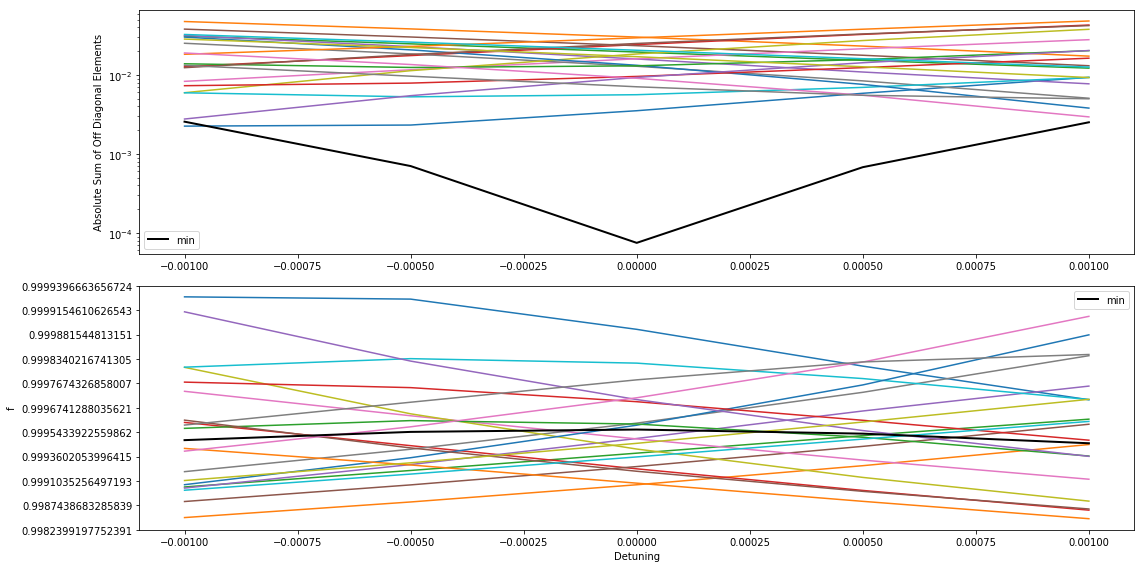

DOING COMBO [0, -0.001]
DOING COMBO [0, -0.0005]
DOING COMBO [0, 0.0]
DOING COMBO [0, 0.0005]
DOING COMBO [0, 0.001]


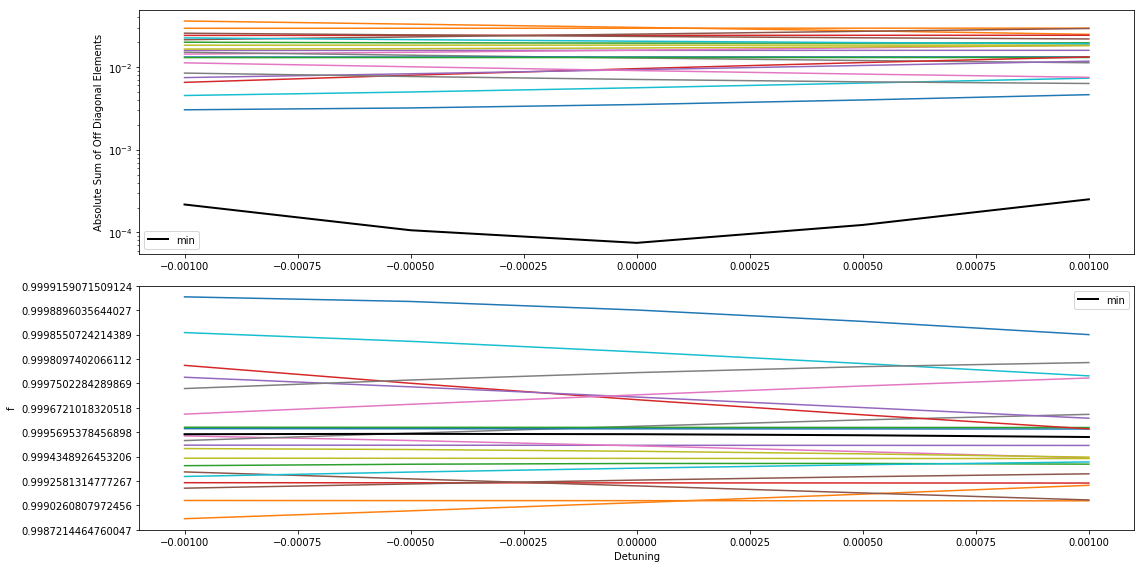

In [13]:
for index in range(len(pca.control_hamiltonians)):
    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0], detuning[0], num_points)
        if i == index:
            values_to_plot.append(values)
        else:
            values_to_plot.append([0])
        corr.append(i)
        
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = itertools.product(*values_to_plot)
    new_combinations = []
    for combo in combinations:
        new_combo = []
        for index in corr:
            new_combo.append(combo[index])
        new_combinations.append(new_combo)
    combinations = new_combinations
    
    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure
    indices = list(range(len(values)))
    for i, row in enumerate(projs[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(values, reordered_row)
    plt.plot(values, [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.subplot(212)  # the second subplot in the first figure
    for i, row in enumerate(fidelities[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(values, -np.log(1 - reordered_row))
    plt.plot(values, [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Detuning")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()


# This is an example of how plots were generated in the old version of the paper - where we sample a grid of detuning values. If you could manage a heat map on a cluster, I think that would look really neat.

DOING COMBO [-0.001, -0.001]
DOING COMBO [-0.001, 0.001]
DOING COMBO [-0.0005, 0.0005]
DOING COMBO [-0.001, 0.0]
DOING COMBO [-0.0005, -0.0005]
DOING COMBO [0.0, -0.001]
DOING COMBO [-0.0005, 0.0]
DOING COMBO [-0.0005, -0.001]
DOING COMBO [-0.0005, 0.001]
DOING COMBO [-0.001, -0.0005]
DOING COMBO [0.0, -0.0005]
DOING COMBO [-0.001, 0.0005]
DOING COMBO [0.0, 0.0]
DOING COMBO [0.0, 0.001]
DOING COMBO [0.0005, -0.0005]
DOING COMBO [0.0005, 0.0005]
DOING COMBO [0.001, -0.001]
DOING COMBO [0.001, 0.0]
DOING COMBO [0.0, 0.0005]
DOING COMBO [0.0005, 0.0]
DOING COMBO [0.0005, -0.001]
DOING COMBO [0.001, -0.0005]
DOING COMBO [0.001, 0.0005]
DOING COMBO [0.0005, 0.001]
DOING COMBO [0.001, 0.001]


/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


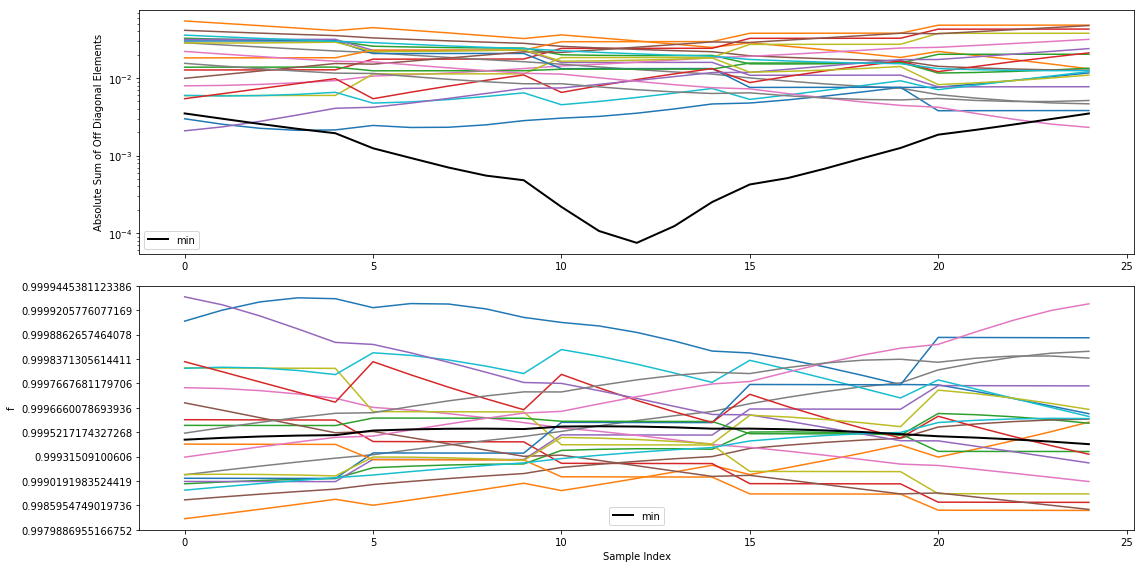

In [6]:
def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
    return indices

values_to_plot = []
corr = []
for i, detuning in enumerate(pca.detunings):
    # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
    values = np.linspace(-detuning[0], detuning[0], num_points)
    values_to_plot.append(values)
    corr.append(i)
# This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
combinations = itertools.product(*values_to_plot)
new_combinations = []
for combo in combinations:
    new_combo = []
    for index in corr:
        new_combo.append(combo[index])
    new_combinations.append(new_combo)
combinations = new_combinations

tuple_length = len(combinations[0])
standard_ordering = list(range(tuple_length))
ordering = standard_ordering
indices = generate_indices(len(values), ordering)

# Multiprocessing for faster evaluation.
pool = multiprocessing.Pool(num_processors)
lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
        pca.control_hamiltonians, pca.target_operator, pca.probs)
       for combo in combinations]
projs_fidelities = pool.map(compute_dpn_and_fid, lst)
pool.close()

# Compute the off diagonals and fidelities.
projs = [pf[0] for pf in projs_fidelities]
fidelities = [pf[1] for pf in projs_fidelities]
projs = np.vstack(projs).T
fidelities = np.vstack(fidelities).T
plt.figure(figsize=(16, 8))  # the first figure
plt.subplot(211)  # the first subplot in the first figure

for i, row in enumerate(projs[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), reordered_row)
plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("Absolute Sum of Off Diagonal Elements")
plt.semilogy()
plt.subplot(212)  # the second subplot in the first figure
for i, row in enumerate(fidelities[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), -np.log(1 - reordered_row))
plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("f")
samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
labels = -(np.exp(-samples) - 1)
plt.xlabel("Sample Index")
plt.tight_layout()
plt.yticks(samples, labels)
plt.tight_layout()
plt.show()


In [7]:
#The order and value of the detunings plotted is given by:
print([combinations[i] for i in indices])

[[-0.001, -0.001], [-0.001, -0.0005], [-0.001, 0.0], [-0.001, 0.0005], [-0.001, 0.001], [-0.0005, -0.001], [-0.0005, -0.0005], [-0.0005, 0.0], [-0.0005, 0.0005], [-0.0005, 0.001], [0.0, -0.001], [0.0, -0.0005], [0.0, 0.0], [0.0, 0.0005], [0.0, 0.001], [0.0005, -0.001], [0.0005, -0.0005], [0.0005, 0.0], [0.0005, 0.0005], [0.0005, 0.001], [0.001, -0.001], [0.001, -0.0005], [0.001, 0.0], [0.001, 0.0005], [0.001, 0.001]]


/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/ma/core.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


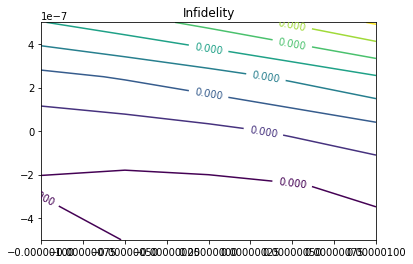

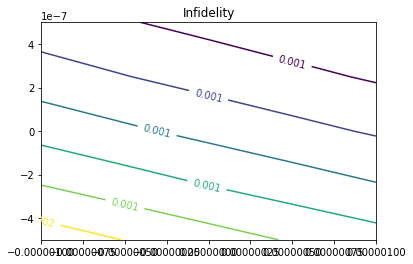

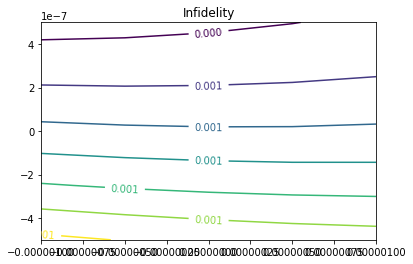

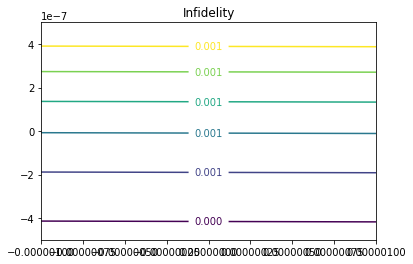

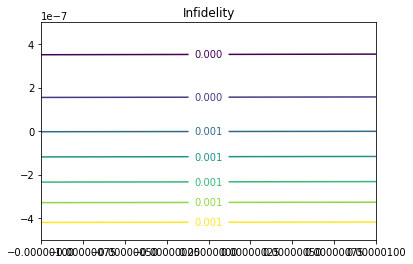

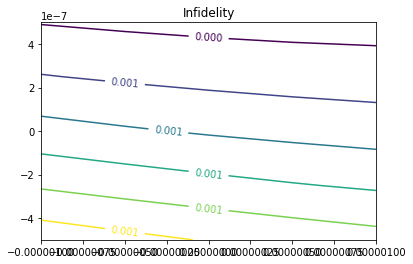

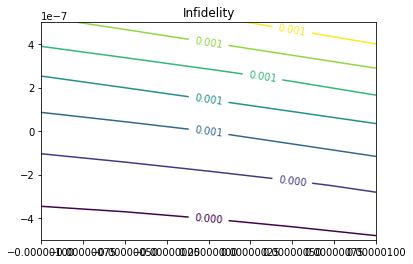

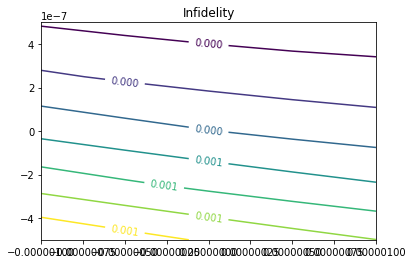

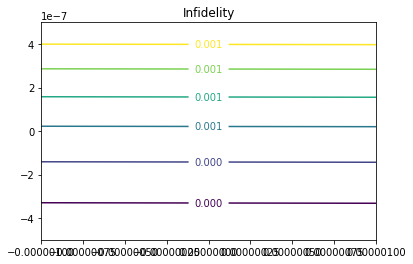

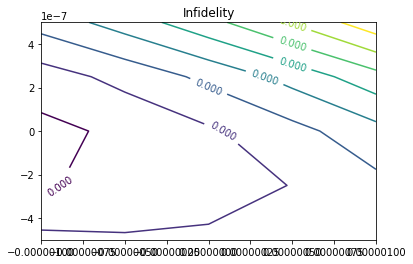

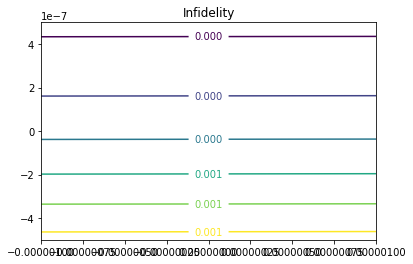

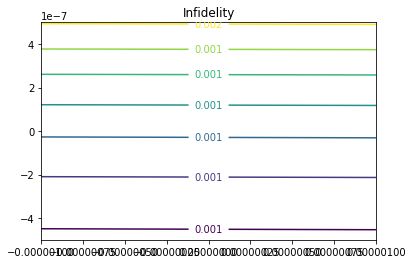

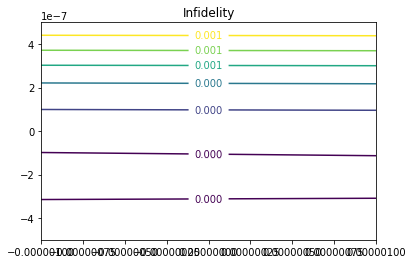

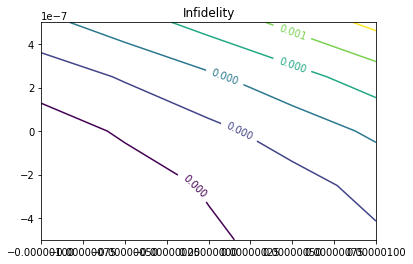

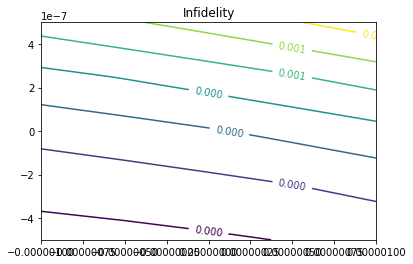

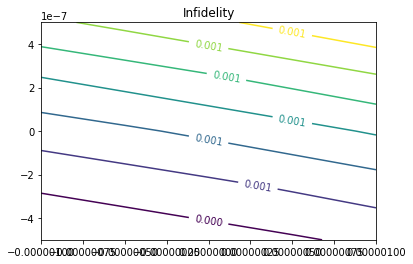

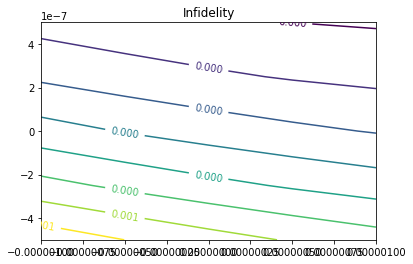

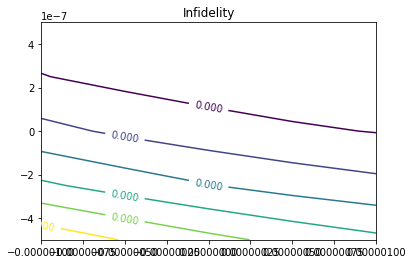

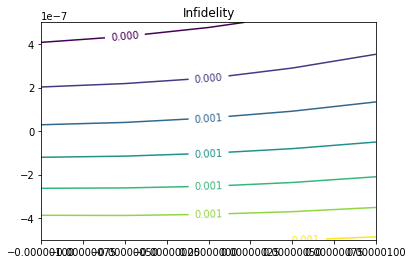

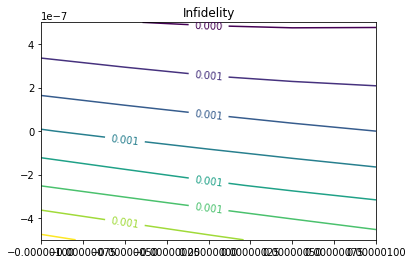

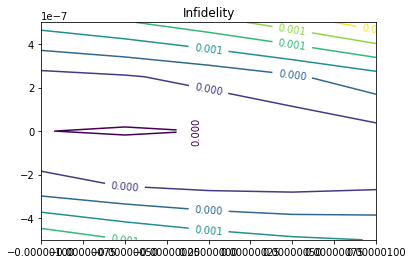

In [18]:
fidelities = np.reshape(fidelities, (fidelities.shape[0], num_points, num_points))
sample_points = np.outer(values, values)

for fid in fidelities:
    import matplotlib
    import numpy as np
    import matplotlib.cm as cm
    import matplotlib.mlab as mlab
    import matplotlib.pyplot as plt

    X = sorted(set(list(zip(*sample_points))[0]))
    Y = sorted(set(list(zip(*sample_points))[1]))
    X, Y = np.meshgrid(X, Y)
    fid = fid.reshape(len(X), len(X))
    fid = 1 - fid
    Z = fid 
    plt.figure()
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Infidelity')
    plt.show()